# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
holding

,Price in USDT,Weights in %
Total,1848.856095,1.000000e+00
BTCUSDT,762.643047,4.124945e-01
JASMYUSDT,299.737689,1.621206e-01
OMUSDT,217.717450,1.177579e-01
SOLUSDT,207.825536,1.124076e-01
ETHUSDT,200.829964,1.086239e-01
BBUSDT,106.768387,5.774835e-02
BNBUSDT,53.279182,2.881738e-02
TRXUSDT,0.054838,2.966043e-05
PEPEUSDT,0.000002,1.099491e-09


In [7]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [8]:
inventory_weights=(holding['Weights in %'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

1.0

In [9]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [10]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

### Positions

In [11]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [12]:
positions=Binance.get_positions_history(enddate=datetime.datetime.today()-datetime.timedelta(1),
                                        startdate=datetime.datetime(2024,5,5))
positions=positions.iloc[:-1]

2024-05-05 00:00:00
2024-06-04 00:00:00
2024-07-04 00:00:00
LDUMAUSDT not retrieved
LDUMAUSDT


In [13]:
positions=positions.sort_index()

In [14]:
positions.index=pd.to_datetime(positions.index)

In [15]:
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

In [16]:
positions.to_excel('Positions.xlsx')

In [17]:
positions['Total']=positions.sum(axis=1)
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total']).fillna(0)

In [18]:
binance_data=Binance.get_price(positions.columns,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()

binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [19]:
historical_ptf=pd.DataFrame()

In [20]:
for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

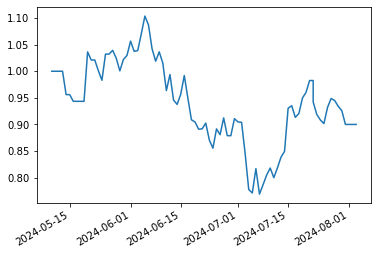

In [21]:
historical_ptf.dropna(axis = 0, how = 'all', inplace = True)
(1+historical_ptf['Historical Portfolio']).cumprod().plot()

### Ex ante data

In [22]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

In [23]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use)
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [24]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APTUSDT', 'ARBUSDT', 'ARUSDT',
       'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT', 'BONKUSDT',
       'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'DYDXUSDT', 'EGLDUSDT', 'ENSUSDT',
       'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT',
       'FLOKIUSDT', 'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT',
       'ICPUSDT', 'IMXUSDT', 'INJUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MATICUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'NEXOUSDT',
       'OMUSDT', 'OPUSDT', 'ORDIUSDT', 'PEPEUSDT', 'QNTUSDT', 'RUNEUSDT',
       'SANDUSDT', 'SEIUSDT', 'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT',
       'THETAUSDT', 'TIAUSDT', 'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT',
       'WBETHUSDT', 'WBTCUSDT', 'XECUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [25]:
limit=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0]

## Optimal Portfolio

In [26]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory

,Weights
OMUSDT,0.437070
BTCUSDT,0.400000
PEPEUSDT,0.071684
JASMYUSDT,0.062021
BNBUSDT,0.029225


In [27]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [28]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current

,Weights
OMUSDT,0.6
BTCUSDT,0.4


## Real Portfolio vs Optimal

In [29]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights in %']-current_holding_comparison['Weights']
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,762.643047,4.124945e-01,0.4,0.012495
JASMYUSDT,299.737689,1.621206e-01,0.0,0.000000
OMUSDT,217.717450,1.177579e-01,0.6,-0.482242
SOLUSDT,207.825536,1.124076e-01,0.0,0.000000
ETHUSDT,200.829964,1.086239e-01,0.0,0.000000
BBUSDT,106.768387,5.774835e-02,0.0,0.000000
BNBUSDT,53.279182,2.881738e-02,0.0,0.000000
TRXUSDT,0.054838,2.966043e-05,0.0,0.000000
PEPEUSDT,0.000002,1.099491e-09,0.0,0.000000


In [30]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights in %']-historical_comparison['Weights']
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights in %,Weights,Spread
BTCUSDT,762.643047,4.124945e-01,0.400000,0.012495
JASMYUSDT,299.737689,1.621206e-01,0.062021,0.100100
OMUSDT,217.717450,1.177579e-01,0.437070,-0.319312
SOLUSDT,207.825536,1.124076e-01,0.000000,0.000000
ETHUSDT,200.829964,1.086239e-01,0.000000,0.000000
BBUSDT,106.768387,5.774835e-02,0.000000,0.000000
BNBUSDT,53.279182,2.881738e-02,0.029225,-0.000408
TRXUSDT,0.054838,2.966043e-05,0.000000,0.000000
PEPEUSDT,0.000002,1.099491e-09,0.071684,-0.071684


## Risk Reward Analysis

In [31]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [32]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

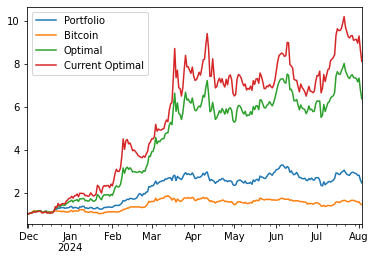

In [33]:
(1+portfolio_perf).cumprod().plot()

In [34]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

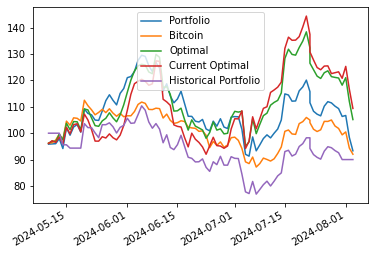

In [35]:
((1+current_perf).cumprod()*100).plot()

In [36]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)

vol

Portfolio    0.731388
dtype: float64

In [37]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)

vol

Portfolio    0.545657
dtype: float64

In [38]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.518912
Bitcoin            0.436499
Optimal            0.732822
Current Optimal    0.878447
dtype: float64

In [39]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.31907950751472886

In [40]:
perf_analysis=pd.concat([historical_risk.perf_contrib_pct(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.003614,0.006337,0.008289,0.000400,0.007889
BTCUSDT,0.021367,0.061625,0.154189,0.056766,0.097423
JASMYUSDT,0.011847,0.017182,0.038754,0.009383,0.029371
OMUSDT,0.943414,0.889578,0.737208,0.640365,0.096842
PEPEUSDT,0.019758,0.025279,0.061559,0.017620,0.043939


In [41]:
perf_analysis=pd.concat([current_risk.perf_contrib_pct(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution in %,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.743157,0.397005,0.249813,0.079620,0.170193
JASMYUSDT,-0.237109,0.175490,0.271371,0.103807,0.167563
OMUSDT,-0.953860,0.161887,0.138008,0.040170,0.097839
SOLUSDT,0.325897,0.101579,0.118305,0.019811,0.098494
ETHUSDT,0.165735,0.107826,0.081452,0.010433,0.071018
BBUSDT,0.842107,0.029493,0.121180,0.031282,0.089899
BNBUSDT,0.114073,0.026721,0.019872,0.000622,0.019250


## Value At Risk

### Historical

In [42]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.06154914155300561, -0.08689824933242882)

In [43]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.051333107387390546, -0.06899760829515593)

In [44]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [45]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.010157
JASMYUSDT   -0.014064
OMUSDT      -0.010547
SOLUSDT     -0.008173
ETHUSDT     -0.003446
BBUSDT      -0.004250
BNBUSDT     -0.001040
TRXUSDT      0.000000
PEPEUSDT    -0.000000
Portfolio   -0.051679
Name: 2024-08-03 00:00:00, dtype: float64

In [46]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.017515
JASMYUSDT   -0.016009
OMUSDT      -0.013358
SOLUSDT     -0.008989
ETHUSDT     -0.005886
BBUSDT      -0.005566
BNBUSDT     -0.001675
TRXUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.068998
dtype: float64

### Parametric

In [47]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.07593212809485746, -0.0973239941469092)

In [48]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.056538854657667614, -0.07246717954357529)

### Multivariate

In [49]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.06607865454911903, -0.0853264612750474)

In [50]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.0555305684241078, -0.0697668823053777)

In [51]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
  

### Copulas

In [52]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06681388865300808, -0.08707442646149041)

In [53]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05612962331486235, -0.07018920707923805)

In [54]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.015050
JASMYUSDT   -0.013945
OMUSDT      -0.007444
SOLUSDT     -0.006898
ETHUSDT     -0.004658
BBUSDT      -0.007028
BNBUSDT     -0.001085
Portfolio   -0.056107
dtype: float64

In [55]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06901886953212859, -0.0892115736916449)

In [56]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.056181917733787855, -0.07155544076022613)

In [57]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

BTCUSDT     -0.014695
JASMYUSDT   -0.015794
OMUSDT      -0.006518
SOLUSDT     -0.006334
ETHUSDT     -0.005142
BBUSDT      -0.007560
BNBUSDT     -0.001203
Portfolio   -0.057247
dtype: float64

### Monte Carlo

In [58]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [59]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.07567468912092402, -0.09488918759687096)

In [60]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05785260552853923, -0.07248650975741702)

In [61]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

BTCUSDT     -0.013708
JASMYUSDT   -0.016420
OMUSDT      -0.007975
SOLUSDT     -0.006795
ETHUSDT     -0.004136
BBUSDT      -0.007568
BNBUSDT     -0.001076
Portfolio   -0.057679
dtype: float64

### VaR Violation

In [62]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.058537,-0.103382,-0.086529,-0.025555
2024-01-15,-0.058537,-0.103378,-0.088301,0.015941
2024-01-16,-0.058537,-0.104066,-0.084752,0.056324
2024-01-17,-0.058537,-0.106220,-0.091336,-0.034131
2024-01-18,-0.058537,-0.108368,-0.096710,-0.036237
...,...,...,...,...
2024-07-30,-0.101999,-0.094582,-0.087838,-0.001903
2024-07-31,-0.101999,-0.095094,-0.092157,-0.022417
2024-08-01,-0.101999,-0.095356,-0.086394,0.024008
2024-08-02,-0.108073,-0.101269,-0.097200,-0.074109


In [63]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.036967,-0.090347,-0.080915,-0.018360
2024-05-29,-0.027954,-0.086551,-0.077049,-0.015326
2024-05-30,-0.027954,-0.075539,-0.066300,0.039371
2024-05-31,-0.026593,-0.071860,-0.059944,0.015909
2024-06-01,-0.026593,-0.072334,-0.060507,0.035195
...,...,...,...,...
2024-07-30,-0.035261,-0.048825,-0.048230,-0.008293
2024-07-31,-0.035261,-0.051389,-0.051770,-0.027312
2024-08-01,-0.035261,-0.050108,-0.049795,0.003394
2024-08-02,-0.071916,-0.068181,-0.076427,-0.077717


<AxesSubplot:>

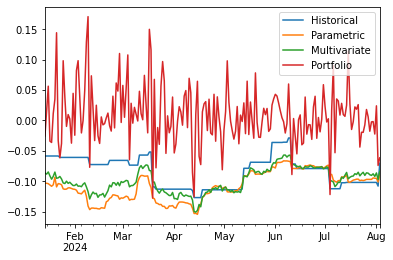

In [64]:
var_data.plot()

<AxesSubplot:>

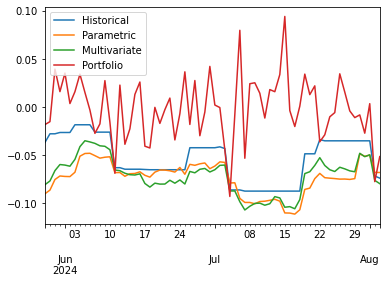

In [65]:
current_var_data.plot()

In [66]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.024631,0.009852,0.014778
Kupiec Stat,3.355963,10.142368,7.248704
P-value,0.066962,0.001449,0.007095


In [67]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.088235,0.044118,0.044118
Kupiec Stat,1.721885,0.051493,0.051493
P-value,0.189451,0.820486,0.820486


## Principal Component Analysis

In [68]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.76669005, 0.07411334, 0.06163398, 0.05418179, 0.04338083])

In [69]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.62121292, 0.1674452 , 0.09768139, 0.07858459, 0.0350759 ])

In [70]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))

<AxesSubplot:>

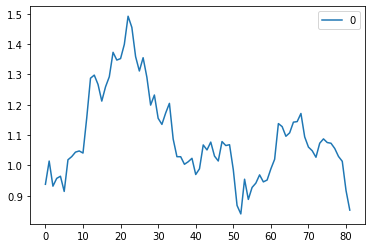

In [71]:
x=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)))
x=x.dropna()
(1+x).cumprod().plot()

<AxesSubplot:>

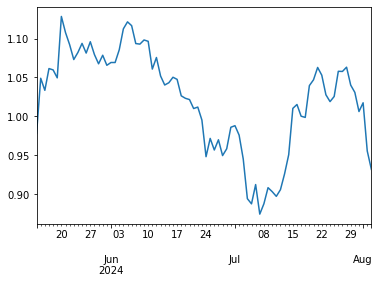

In [72]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()